# Brute Force Utility Functions

In this notebook we write some functions that will be useful for opening & analysing the output from our stochastic integrations of the L96 EBM model.

In [82]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.stats import gaussian_kde
import pickle

In [2]:
%load_ext line_profiler

In [3]:
# Data Directories

# k5_eps0_1_dir = '/rds/general/user/cfn18/ephemeral/L96-EBM-Stochastic/k5_eps0_1/'
# k5_eps0_01_dir = '/rds/general/user/cfn18/ephemeral/L96-EBM-Stochastic/k5_eps0_01/'
# k20_eps0_01_dir = '/rds/general/user/cfn18/ephemeral/L96-EBM-Stochastic/k20_eps0_01/'

small_dir = '/rds/general/user/cfn18/ephemeral/L96-EBM-Stochastic/k20_eps0_1_SHORT'
big_dir = '/rds/general/user/cfn18/ephemeral/L96-EBM-Stochastic/k20_eps0_1'

### Function for input/output

Some notes:

- From a linecheck it seems 95% + of the time is spent my xr.open_mfdataset

In [6]:
def list_runs(d, s=slice(0, -1, 1)):
    """
    Get list of all directories containing *.nc files in array jobs run.
    
    d, param, string
        Name of array jobs directory.
    s, param, slice
        Slice to index the array jobs we filter through.
    
    run_list, output, list
        List of directory names.
        Each directory will contatin a load of .nc files.
    """
    run_list = [] 
    runs = os.listdir(d) # list of array job runs
    runs.sort(key=float)
    for file in runs[s]:
        folder = d + '/' + file +'/'
        for Tfile in os.listdir(folder):
            subfolder = folder + Tfile
            run_list.append(subfolder)
    return run_list

In [7]:
k20_run_list = list_runs(big_dir)

In [8]:
def load_runs(d_list, prog=True):
    """
    Load a list of runs.
    
    d_list, param, list
        List of directory names.
        Each should contain many .nc files

    results, output, list
        List of xarray datasets.   
    """
    results = [] 
    
    for directory in tqdm(d_list, disable = not prog):
        try:
            ds = xr.open_mfdataset(directory + '/*.nc', combine='by_coords', concat_dim='time')
            results.append(ds)
        except:
            print(f'Error opening {directory}')
    return results

In [10]:
k20_runs = load_runs(k20_run_list[20:23])

Error opening /rds/general/user/cfn18/ephemeral/L96-EBM-Stochastic/k20_eps0_1/11/T_258_485884



In [11]:
def close_list(run):
    for ds in run:
        ds.close()
    print('Closed Runs')

In [12]:
close_list(k20_runs)

Closed Runs


### Function for sorting out array jobs results

In [13]:
def re_test(ds, thres=(270, 280)):
    """
    Tests if a L96 EBM dataset contains a transition.
    Returns boolean.
    
    ds, xr.dataset, param
        Dataset containing the L96 EBM run.
        
    thres, tuple, param
        Thresholds for transition test.
        Form is (cold, hot).
        Transition defined by (x<cold & x>hot) in the timeseries.
        
    transition, boolean, output
        Did we have a transition?
    """
    cold = ds.T.values<thres[0]
    hot = ds.T.values>thres[1]
    transition = np.any(cold) & np.any(hot)
    return transition
  

In [60]:
def sort_runs(run_list, thres=(270, 280), prog=False):
    """
    Sorts an array jobs directory in to transitions, no transitions and corrupt runs.
    
    run_list, param, list
        List of directory names.
        Can be produced by list_runs() for example.
        Each directory should contatin a load of .nc files.
    thres, option, tuple
        Thresholds used to test for transitions (see re_test).
    prog, option, boolean
        Do you want a progress bar?
        
    [re_list, boring_list, corrupt_list], output, list
        re_list is are directories containing a transition.  
    """

    re_list = []
    boring_list = []
    corrupted_list = []
    
    if (prog):
        print(f'{len(run_list)} runs to sort')
        
    for run in tqdm(run_list, disable=(not prog)):
        corrupted = False
        try:
            # Open and check if it contains a transition
            with xr.open_mfdataset(run + '/*.nc', combine='by_coords', concat_dim='time') as ds:
                rare = re_test(ds, thres)
        except:
            print(f'Error opening {run}')
            corrupted = True
            
        # Add to the correct list
        if corrupted:
            corrupted_list.append(run)
        elif ((not corrupted) & rare):
            re_list.append(run)
        elif (not corrupted):
            boring_list.append(run)
            
    return [re_list, boring_list, corrupted_list]

In [61]:
k20_runs = list_runs(big_dir)

In [17]:
run_dir = '/rds/general/user/cfn18/ephemeral/L96-EBM-Stochastic/k20_eps0_1'
local_dir = 'Data/k20_eps0_1/'

In [73]:
def pickler(l, s):
    with open(s + '.pickle', 'wb') as output_file:
        pickle.dump(l, output_file)
        
def unpickler(s):
    with open(s + '.pickle', "rb") as input_file:
        return pickle.load(input_file)
        

In [72]:
int(6/5)

1

In [74]:
def sort_n_save(run_list, save, prog=False):
    """
    Sorts a list of run directories in to rare ones, boring ones
    and corrupt ones. Pickles sorted lists at save.
    
    run_list, param, list
        List of run directories.
    save, param, string
        Where to save output.
    prog, option, boolean
        Want a progress bar?
    """
    
    # Lists contain rare, boring and corrupt run directories
    r_list = []
    b_list = []
    c_list = []
    lists = [r_list, b_list, c_list]
    list_names = ['rare_list', 'boring_list', 'corrupt_list']

    # Break run list in to chunks of ~5
    chunk_size = int(len(run_list)/5)

    for chunk in tqdm(np.array_split(np.array(run_list), chunk_size), disable =(not prog)):

        rare, boring, corr = sort_runs(chunk)
        r_list += rare
        b_list += boring
        c_list += corr

        # Save output for each chunk
        for l, name in zip(lists, list_names):
            pickler(l, save + name)
            
    return
        

In [ ]:
sort_n_save(k20_runs[:11], save_location, prog=True)

 50%|█████     | 1/2 [00:54<00:54, 54.39s/it]

In [81]:
for name in list_names:
    l = unpickler(save_location + name)
    print(len(l))

2
9
0


In [22]:
b_list += '1'

In [23]:
all_lists

[['1'], ['1'], []]

In [109]:
# Split check in to Blocks
bl = 2
length = int(len(k20_runs))
remainder = length%bl
no_of_blocks = int((length - remainder)/bl)
slices = [slice(i * bl, (i + 1) * bl) for i in range(no_of_blocks)]
if remainder != 0:
    remainder_slice = slice(length - remainder, length)
    slices.append(remainder_slice)
print(f'There are {len(slices)} blocks to search')

r_list = []
b_list = []
c_list = []
all_lists = [r_list, b_list, c_list]
names = ['rare_list', 'boring_list', 'corrupt_list']
for name, l in zip(names, all_lists):
    pickler(l, local_dir + name)
    
for name in names:
    all_lists = [unpickler(local_dir + name) for name in names]
    
for name, s in zip(names, tqdm(slices[:2])):
    runs = k20_runs[s]
    r, b, c = sort_runs(runs)
    for (l, x) in zip(all_lists, [r, b, c]):
        l += x
        pickler(l, local_dir + name)

There are 490 blocks to search


2 runs to sort
2 runs to sort



In [88]:
pickler(k20_re, local_dir + 'rare_list')

In [76]:
k20_re, k20_bo, k20_cor = sort_runs(k20_runs[8:12], prog=True)

4 runs to sort


/rds/general/user/cfn18/ephemeral/L96-EBM-Stochastic/k20_eps0_1/5/T_256_814006
/rds/general/user/cfn18/ephemeral/L96-EBM-Stochastic/k20_eps0_1/5/T_293_171261
/rds/general/user/cfn18/ephemeral/L96-EBM-Stochastic/k20_eps0_1/6/T_295_112701
/rds/general/user/cfn18/ephemeral/L96-EBM-Stochastic/k20_eps0_1/6/T_258_319165



### Functions for finding Transitions

In [216]:
def get_re_dirs(run_name, s=slice(0, -1, 1), thres=(270, 280), prog=False):
    """
    Finds all the directories containing a transition in an array jobs run.
    Recommended to use this when you're searching small directories.

    run_name, param, string
        Array jobs run directory.
    s, option, slice
        Slice for indexing runs in array jobs run.
    thres, option, tuple
        Thresholds used to test for transitions (see re_test).
    prog, option, boolean
        Do you want a progress bar?
        
    re_list, output, list
        List of directories containing a transition.
    """
    re_list = []
    boring_list = []
    corrupted_list = []
    run_list = list_runs(run_name, s)
        
    for run in tqdm(run_list, disable=(not prog)):
        corrupted = False
        
        # Open and check if it contains a transition
        try:
            with xr.open_mfdataset(run + '/*.nc', combine='by_coords', concat_dim='time') as ds:
                rare = re_test(ds, thres)
        except:
            print(f'Error opening {run}')
            corrupted = True
            
        # Make a note of rare ones
        if corrupted:
            corrupted_list.append(run)
        elif (not corrupted & rare):
            re_list.append(run)
        elif (not corrupted):
            boring_list.append(run)
    return re_list, boring_list, corrupted_list

In [207]:
print('a')

a


In [217]:
re_list, boring_list, corrupted_list = get_re_dirs(big_dir, slice(12, 13), prog=True)

2 runs to sort


In [220]:
xr.open_mfdatatere_list[0]

['/rds/general/user/cfn18/ephemeral/L96-EBM-Stochastic/k20_eps0_1/13/T_258_764058']

In [196]:
def re_search(run_name, save, thres=(270, 280), bl=5):
    """
    Searches an array job run for transitions.
    Saves a pickled list of the directories.
    Recommended to use this when you're searching large directories.
    
    
    run_name, param, string
        The array jobs directory we're searching.
    save, param, string
        File name for outputted list of transition directories.
    thres, option, tuple
        Thresholds used to test for transitions (see re_test).
    bl, option, int
        How often we save.
    """
    
    re_list = []
    
    # Split check in to Blocks
    length = int(len(os.listdir(run_name)))
    remainder = length%bl
    no_of_blocks = int((length - remainder)/bl)
    slices = [slice(i * bl, (i + 1) * bl) for i in range(no_of_blocks)]
    if remainder != 0:
        remainder_slice = slice(length - remainder, length)
        slices.append(remainder_slice)
    print(f'There are {len(slices)} blocks to search')

    # Search each block for rare events
    for sl in tqdm(slices):
        block_res = get_re_dirs(run_name, sl)
        re_list += block_res
        
        # Savepoint after block searched
        with open(save, "wb") as file:
            pickle.dump(re_list, file)

    


In [ ]:
re_search(big_dir, 'Transitions/k20_eps0_1/re_list.pickle')

There are 100 blocks to search


Found one!
Found one!


In [197]:
error_file = (
    '/rds/general/user/cfn18/ephemeral/L96-EBM-Stochastic/k20_eps0_1/11/T_258_485884/'
    + 'L96-EBM-Stochastic-Trajectory992.nc'
)

In [186]:
ds = xr.open_dataset(error_file)

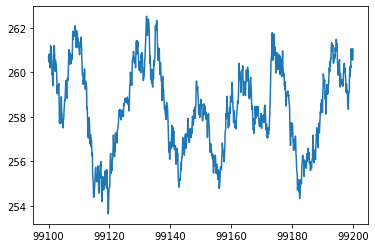

In [187]:
plt.plot(ds.time, ds.T)

In [139]:
re_dirs_block(small_dir, 'Transitions/re_list.pickle')

There are 20 blocks to search


Found one!



In [ ]:
Instantons/L96-EBM-Instanton/Brute-Force/Transitions/k20_eps0_1/re_list.pickle

In [163]:
with open('Transitions/re_list_test.pickle', "rb") as file:
    a = pickle.load(file)

In [164]:
a

['/rds/general/user/cfn18/ephemeral/L96-EBM-Stochastic/k40_eps0_1_SHORT/43/T_290_437369']

In [132]:
# Split check in to Blocks
re_list = []

bl = 5
length = int(len(os.listdir(big_dir)))
remainder = length%bl
no_of_blocks = int((length - remainder)/bl)

slices = [slice(i * bl, (i + 1) * bl) for i in range(no_of_blocks)]
if remainder != 0:
    remainder_slice = slice(length - remainder, length)
    slices.append(remainder_slice)
print(f'There are {len(slices)} blocks to search')

for sl in tqdm(slices):
    re_list.append(get_re_dirs(small_dir, sl))
    with open(f"{re_dir}/re_list.pickle", "wb") as file:
        pickle.dump(re_list, file)



There are 20 blocks to search


Found one!



In [ ]:
with open(f"{re_dir}/re_list.pickle", "wb") as file:
    pickle.dump(re_list, file)

In [113]:
re_dir = 'Transitions/k20_eps0_1/'
print(re_dir)

Transitions/k20_eps0_1/


In [114]:
with open(f"{re_dir}/re_list.pickle", "wb") as f:
    pickle.dump(a, f)

In [20]:
def re_dir_search_new(d, thres=(270, 280), bl = 5):
    """
    Searchs a whole array jobs run for rare events.
    
    d, param, string
        name of directory containing array jobs run.
    thres, param, tuple
        (cold, hot) threshold.
    bl, param, int
        number of datasets opened at one time.
    
    rare_events, output, list
        List of filenames containing transitions.   
    """

    re_list = []
    
    # Split check in to Blocks
    length = int(len(os.listdir(d)))
    print(f'There are {length} blocks to search')
    remainder = length%bl
    no_of_blocks = int((length - remainder)/bl)

    slices = [slice(i * bl, (i + 1) * bl) for i in range(no_of_blocks)]
    remainder_slice = slice(length - remainder, length)
    slices.append(remainder_slice)
    
    # For each block, open ds and check if there is a rare event
    for s in tqdm(slices):
        print('Loading a block')
        results = load_run(d, s)
        rare_events +=  rare_event_search(results, thres=thres)
        close(results)
        
    print(f'I found {len(rare_events)} transitions')

    return rare_events


In [20]:
def re_dir_search(d, thres=(270, 280), bl = 5):
    """
    Searchs a whole array jobs run for rare events.
    
    d, param, string
        name of directory containing array jobs run.
    thres, param, tuple
        (cold, hot) threshold.
    bl, param, int
        number of datasets opened at one time
    
    rare_events, output, list: list of xarray datasets that have transitions.   
    """

    rare_events = []
    
    # Split Run in to Blocks of 10
    length = int(len(os.listdir(d)))
    print(f'There are {length} blocks to search')
    remainder = length%bl
    no_of_blocks = int((length - remainder)/bl)

    slices = [slice(i * bl, (i + 1) * bl) for i in range(no_of_blocks)]
    remainder_slice = slice(length - remainder, length)
    slices.append(remainder_slice)
    
    # For each block, open ds and check if there is a rare event
    for s in tqdm(slices):
        print('Loading a block')
        results = load_run(d, s)
        rare_events +=  rare_event_search(results, thres=thres)
        close(results)
        
    print(f'I found {len(rare_events)} transitions')

    return rare_events


In [22]:
def rare_event_search(runs, thres=(270, 280)):
    """
    Searchs a list of xarrays for rare event trajectories and stores them in a list.
    
    runs, param, list: list of data sets we're checking.
    thres, param, tuple: (cold, hot) threshold.
    rare_events, output, list: list of xarray datasets that have transitions.   
    """
    rare_events = []
    print('Checking for transition trajectories')
    for ds in tqdm(runs):
        cold = ds.T.values<thres[0]
        hot = ds.T.values>thres[1]
        transition = np.any(cold) & np.any(hot)
        if transition:
            print('Found one!')
            rare_events.append(ds)
    return rare_events

In [11]:
# Example Use

res = rare_event_search(results, thres=(270, 270))

Found one!



In [21]:
# Example Use
re_dir_search(small_dir)

There are 100 blocks to search


Loading a block


NameError: name 'rare_event_search' is not defined

### Functions for Evaluation the Data

In [23]:
def timeseries_plot(t, x, x_name='', save=None):
    "Plots x timeseries"
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.grid()
    ax.set_xlabel('Time')
    ax.set_ylabel(x_name)
    title = 'Timeseries of' + ' ' + x_name
    ax.set_title(title)
    ax.plot(t, x)
    
    if (save is None):
        fig.show()
        return fig, ax # Return in case you want to edit plot options
    else:
        fig.savefig(save)
    return

In [39]:
def summary_stats(d, densities=False):
    "Takes dataset, prints/plots summary stats."
    # Remove Transient
    transient=1000
    ds = d.isel(time=slice(transient,-1))
    
    # T Stats
    T_mean = ds.T.mean().values
    T_var = ds.T.var().values
    print(f'T mean is {T_mean:.2f}\n')
    print(f'T variance is {T_var:.2f}')
    
    if densities:
        density_plot(ds.T.values, 'Temperature PDF', 'T')

    # X Stats Displayed as a plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    for ax in axes:
        ax.grid()
        ax.set_xlabel('Spatial Coordinate')
    axes[0].scatter(ds.X.space, ds.X.mean(dim='time'))
    axes[0].set_ylabel('Time Mean')
    axes[0].set_title('X Means')
    axes[1].scatter(ds.X.space, ds.X.var(dim='time'))
    axes[1].set_ylabel('Time Variance')
    axes[1].set_title('X Variances')
    fig.show()
    
    if densities:
        density_plot(ds.X.values.flatten(), 'X PDF - All Spatial Points', 'X') 

In [42]:
def density_plot(samples, title, xlabel='', save=None):
    "Given data samples uses KDE to plot PDF."
    fig, ax = plt.subplots(figsize=(7, 7))
    x_d = np.linspace(samples.min(), samples.max(), int(len(samples)/100)) # Grid we evaluate PDF on
    kde = gaussian_kde(samples) # KDE. Using Gaussian ker
    pdf = kde.evaluate(x_d)
    ax.plot(x_d, pdf)
    ax.set_ylabel('$\\rho$')
    ax.set_xlabel(xlabel)
#     ax.plot(samples, np.full_like(samples, -0.01), 'k*', label='samples')
#     ax.legend()
    ax.grid()
    ax.set_title(title)
    if (save!=None):
        print(f'Saving plot at {save}')
        fig.savefig(save, dpi=1200)
    fig.show()

T mean is 257.38

T variance is 5.80


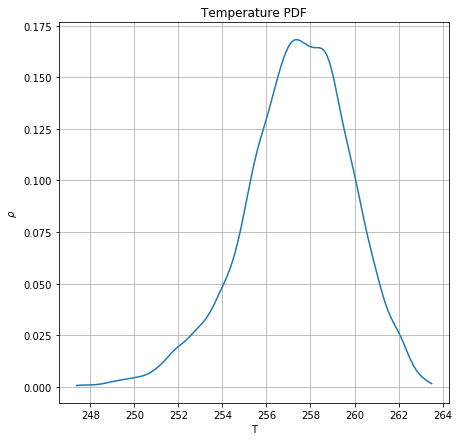

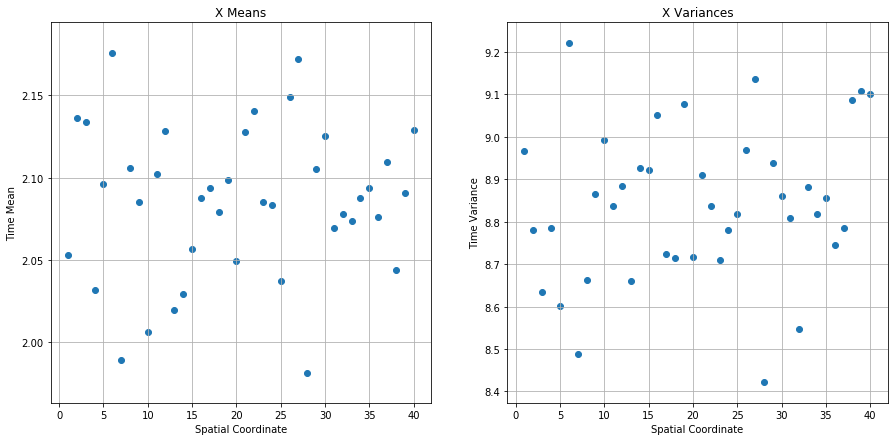

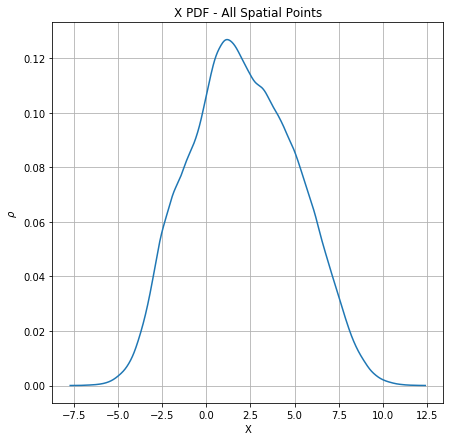

In [43]:
summary_stats(results[1], densities=True)

In [61]:
def energy_time_plot(d, thres=(275, 280)):
    """
    3D plot of energy, time and temperature. 
    Colors attractors according to temperatures in thres.
    
    ds, param, xr.dataset: the data we're plotting.
    thres, param, tuple: (cold, hot). 
        x< cold is blue.
        cold<x<hot is green.
        x> hot is red.
    """
        
    # Remove Transient & thin out
    transient=1000
    ds = d.isel(time=slice(transient,-1))
                
    energy_ts = 0.5 * (ds.X**2).mean(dim='space').values
    
    cold = ds.T.values < thres[0]
    hot = ds.T.values > thres[1]
    transition = (ds.T.values>thres[0]) * (ds.T.values<thres[1])

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.plot(ds.time.values[cold], energy_ts[cold], ds.T.values[cold], 'b')
    ax.plot(ds.time.values[transition], energy_ts[transition], ds.T.values[transition], 'g')
    ax.plot(ds.time.values[hot], energy_ts[hot], ds.T.values[hot], 'r')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('$\\mathcal{E}$')
    ax.set_zlabel('$T$')
    fig.show()
    
    return fig, ax

In [60]:
def energy_mean_plot(d, thres=(275, 280)):
    """
    Attractor Projection Plot.
    3D plot of energy, mean and temperature. 
    Colors attractors according to temperatures in thres.
    
    d, param, xr.dataset: the data we're plotting.
    thres, param, tuple: (cold, hot). 
        x< cold is blue.
        cold<x<hot is green.
        x> hot is red.
    """
    # Remove Transient & thin out
    transient=1000
    ds = d.isel(time=slice(transient,-1))

    energy_ts = 0.5 * (ds.X**2).mean(dim='space').values
    mean_ts = ds.X.mean(dim='space').values

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    cold = ds.T.values < thres[0]
    hot = ds.T.values > thres[1]
    transition = (ds.T.values>thres[0]) * (ds.T.values<thres[1])
    
    ax.plot(mean_ts[cold], energy_ts[cold], ds.T.values[cold], 'b')
    ax.plot(mean_ts[transition], energy_ts[transition], ds.T.values[transition], 'g')
    ax.plot(mean_ts[hot], energy_ts[hot], ds.T.values[hot], 'r')

    ax.set_xlabel('$\\mathcal{M}$')
    ax.set_ylabel('$\\mathcal{E}$')
    ax.set_zlabel('$T$')
    fig.show()
    
    return fig, ax

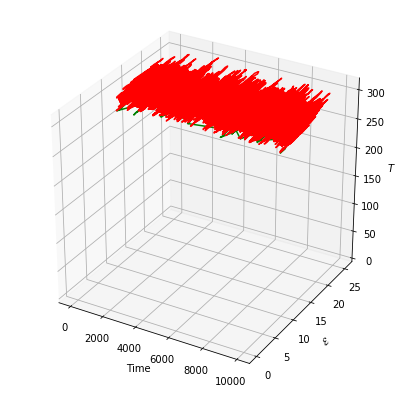

In [65]:
energy_time_plot(results[2])

In [249]:
dire = '/rds/general/user/cfn18/home/Instantons/L96-EBM-Instanton/Brute-Force/TEST/SRI2/T_256_963935'
dire2 = '/rds/general/user/cfn18/home/Instantons//L96-EBM-Instanton/Brute-Force/TEST/SRI2/T_294_440564'
ds = xr.open_mfdataset(dire + '/*.nc', parallel=True, combine='by_coords', concat_dim='time')
ds2 = xr.open_mfdataset(dire2 + '/*.nc', parallel=True, combine='by_coords', concat_dim='time')

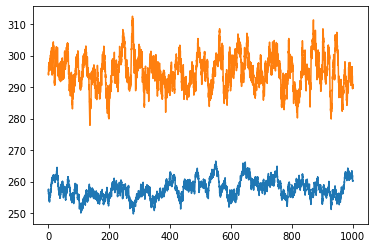

In [251]:
plt.plot(ds.time, ds.T)
plt.plot(ds2.time, ds2.T)

In [254]:
len(ds.time)

10010